Self-Driving Car Engineer Nanodegree

Project: Finding Lane Lines on the Road

Author: Pengmian Yan 

Importing

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from PIL import Image
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Definition of Functions

In [2]:
def create_points_from_lines(x1,y1,x2,y2):
    """Convert line features to feature class of points

    :param input_line: Input line features
    increment = 5
    :return: Output point feature
    """
#     x1 = input_line[0]
#     y1 = input_line[1]
#     x2 = input_line[2]
#     y2 = input_line[3]
    increment = 5
    output_points = []
    output_points.append([x1,y1])
    output_points.append([x2,y2])      
    
    if x1 == x2:
        y = min(y1,y2) + increment
        while y < max(y1,y2):
            output_points.append([x1,y])
            y += increment
    else:
        slope = (y2-y1)/(x2-x1)
        b = y1-x1*slope
        x = min(x1,x2) + increment
        while x < max(x1,x2):
            output_points.append([x,x*slope+b])
            x += increment

    return output_points

def merge_lines(lines, masked_image):
    """
    Input is array of initional line segements.
    The segments will be fittet to one left line and one right line, which will be crossed.
    """

    #devide the line segments to left lines vs. right lines
    lines_left = []
    lines_right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x2!=x1:
                if ((y2-y1)/(x2-x1)) < 0:
                    lines_left.append(line)
                else:
                    lines_right.append(line)
                
    #compute the average slope of left line segments
    slope_left = 0
    summe_slope_left = 0
    length_left = 0
    summe_length_left = 0
    for line in lines_left:
        for x1,y1,x2,y2 in line:
            if x2!=x1:
                length_left = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                slope_left = (y2-y1)/(x2-x1)
                summe_slope_left += slope_left*length_left
                summe_length_left += length_left
    if summe_length_left!= 0:
        average_slope_left = summe_slope_left / summe_length_left
    else:
        average_slope_left = 0 
    #print('average_slope_left=', average_slope_left)

    #take out the outlier of left line segments
    lines_left_good = []
    for line in lines_left:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1) > average_slope_left*1.2) and ((y2-y1)/(x2-x1) < average_slope_left*0.8) and (x1<600) and (x2<600):
                lines_left_good.append(line)
       
    #compute the average slope of right line segments
    slope_right = 0
    summe_slope_right = 0
    length_right = 0
    summe_length_right = 0
    for line in lines_right:
        for x1,y1,x2,y2 in line:
            if x2!=x1:
                length_right = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                slope_right = (y2-y1)/(x2-x1)
                summe_slope_right += slope_right*length_right
                summe_length_right += length_right
    if summe_length_right != 0:
        average_slope_right = summe_slope_right / summe_length_right
    else:
        average_slope_right = 0
#     print('average_slope_right=', average_slope_right)
    
    #take out the outlier of right line segments
    lines_right_good = []
    for line in lines_right:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1) < average_slope_right*1.2) and ((y2-y1)/(x2-x1) > average_slope_right*0.8) and (x1>500) and (x2>500):
                lines_right_good.append(line)
#     print('number of lines_right=',len(lines_right))
#     print('number of lines_right_good=',len(lines_right_good))
          
    #generate points on the left line segments
    points_left = []
    for line in lines_left_good:
        for x1,y1,x2,y2 in line:
            points_left.extend(create_points_from_lines(x1,y1,x2,y2)) 
    #print(points_left)
    #generate points on the right line segments
    points_right = []
    for line in lines_right_good:
        for x1,y1,x2,y2 in line:
            points_right.extend(create_points_from_lines(x1,y1,x2,y2))
#     #draw the points_right to debug
#     blank = np.zeros_like(masked_image)
#     for point in points_right:
#         cv2.circle(blank, (int(point[0]),int(point[1])), 2, (100,0,0),-1)
#     plt.imshow(blank)
    #fit lines to one left line 
    [vx_l,vy_l,x0_l,y0_l] = cv2.fitLine(np.array(points_left), cv2.DIST_FAIR, 0, 1e-2, 1e-2)
    #print('[vx_l,vy_l,x0_l,y0_l]',[vx_l,vy_l,x0_l,y0_l])
    #compute the formel of left line yl=m_l*(x-x0)+y0
    m_l = vy_l/vx_l
    
    #fit lines to one right line 
    [vx_r,vy_r,x0_r,y0_r] = cv2.fitLine(np.array(points_right), cv2.DIST_FAIR, 0, 1e-2, 1e-2)   
    #print('[vx_r,vy_r,x0_r,y0_r]',[vx_r,vy_r,x0_r,y0_r])    
    #compute the formel of left line yl=m_l*(x-x0)+y0
    m_r = vy_r/vx_r
    
    return [m_l,m_r,x0_l,y0_l,x0_r,y0_r]




def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #Grayscale transform
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')

    #Canny transform
    Edge = cv2.Canny(gray, 50, 150)
    plt.imshow(Edge, cmap='gray')

    #Applies a Gaussian Noise kerne
    Edge_clean = cv2.GaussianBlur(Edge, (3, 3), 0)
    plt.imshow(Edge_clean, cmap='gray')

    #Applies an image mask for the ROI
    #defining a blank mask to start with
    mask = np.zeros_like(Edge_clean)
        ##filling pixels inside the polygon defined by "vertices" with the fill color    
    ignore_mask_color = 255
    qradrangle = np.array([[460,313],[490,313],[100,540],[950,540]])
#     qradrangle = np.array([[450,333],[500,333],[100,540],[950,540]])
    cv2.fillPoly(mask, [qradrangle], ignore_mask_color)
        ##returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(Edge_clean, mask)

    # plt.imshow(masked_image)

    #get the hough lines
    rho = 1
    theta = 1
    threshold = 5
    minLinelength = 10
    maxLineGap = 4
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLinelength, maxLineGap)
        ##Merge the lins
    lines_merged = merge_lines(lines,masked_image) #right
#     print('[m_l,m_r,x0_l,y0_l,x0_r,y0_r]=',lines_merged)

    #compute the cross point of left and right line
    m_l = lines_merged[0]
    m_r = lines_merged[1]
    x0_l = lines_merged[2]
    y0_l = lines_merged[3]  
    x0_r = lines_merged[4]
    y0_r = lines_merged[5]
    x_cross = (y0_r-y0_l + m_l*x0_l - m_r*x0_r)/(m_l-m_r)

    #compute the two end points of left line
    endpoints_left = [x_cross-10, m_l*(x_cross-10-x0_l)+y0_l, x0_l+(image.shape[0]-y0_l)/m_l, image.shape[0]]
#     print('endpoints_left =',endpoints_left)
    #compute the two end points of right line

    endpoints_right = [x_cross+10, m_r*(x_cross+10-x0_r)+y0_r, x0_r+(image.shape[0]-y0_r)/m_r, image.shape[0]]
#     print('endpoints_right =',endpoints_right)

    # endpoints = np.vstack((endpoints_left,endpoints_right))
    # print('endpoints',endpoints)
    #draw_lines(masked_image, lines, color=[255, 0, 0], thickness=2)
    # blank = np.zeros_like(masked_image)
    # for point in points:
    #         cv2.circle(blank, (int(point[0]),int(point[1])), 2, (100,0,0),-1)

    #plt.imshow(blank);

    #print(outputs_points)
    lines_img = np.zeros((masked_image.shape[0],masked_image.shape[1],3), dtype=np.uint8)
    #draw_lines(lines_img, endpoints)
    cv2.line(lines_img, (endpoints_left[0], endpoints_left[1]), (endpoints_left[2], endpoints_left[3]), [255,0,0], 10)
    cv2.line(lines_img, (endpoints_right[0], endpoints_right[1]), (endpoints_right[2], endpoints_right[3]), [255,0,0], 10)
    plt.imshow(lines_img)

    # put the lines on the inital image
    result_img = cv2.addWeighted(image, 0.8, lines_img, 1, 0)
    return result_img

Main function for lane finding pipline on a image

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 35%|███▍      | 77/222 [00:07<00:17,  8.45it/s]

error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/imgproc/src/linefit.cpp:605: error: (-215) npoints2 >= 0 || npoints3 >= 0 in function fitLine


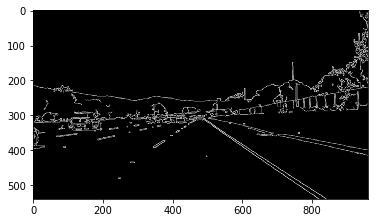

In [3]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)